In [1]:
from gplearn.genetic import SymbolicRegressor,SymbolicClassifier,SymbolicTransformer
from gplearn.fitness import make_fitness
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_boston
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import graphviz
import pydotplus

# SymbolicRegressor符号回归器

## 准备原始数据 
基于y=X02-x1^2+x1-1的数据生成分布

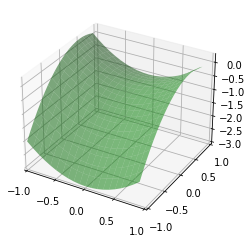

In [2]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()

## 根据数据生成分布生成随机的训练集和测试集

In [3]:
rng = check_random_state(0)
x_train = rng.uniform(-1,1,100).reshape(50,2)
y_train = x_train[:,0]**2-x_train[:,1]**2+x_train[:,1]-1
x_test = rng.uniform(-1,1,100).reshape(50,2)
y_test = x_test[:,0]**2-x_test[:,1]**2+x_test[:,1]-1
x_train

array([[ 0.09762701,  0.43037873],
       [ 0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823],
       [-0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696],
       [ 0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328],
       [-0.85792788, -0.8257414 ],
       [-0.95956321,  0.66523969],
       [ 0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713],
       [-0.07704128,  0.56105835],
       [-0.76345115,  0.27984204],
       [-0.71329343,  0.88933783],
       [ 0.04369664, -0.17067612],
       [-0.47088878,  0.54846738],
       [-0.08769934,  0.1368679 ],
       [-0.9624204 ,  0.23527099],
       [ 0.22419145,  0.23386799],
       [ 0.88749616,  0.3636406 ],
       [-0.2809842 , -0.12593609],
       [ 0.39526239, -0.87954906],
       [ 0.33353343,  0.34127574],
       [-0.57923488, -0.7421474 ],
       [-0.3691433 , -0.27257846],
       [ 0.14039354, -0.12279697],
       [ 0.97674768, -0.79591038],
       [-0.58224649, -0.67738096],
       [ 0.30621665,

## 训练一个符号回归器
初始阶段5000颗公式树，20代，交叉0.7，子树变异0.1，hoist变异0.05，点变异0.1，每一代样本选取0.9，节俭参数0.01

In [7]:
est_gp = SymbolicRegressor(population_size=5000,generations=20,stopping_criteria=0.01,p_crossover=0.7,
                           p_subtree_mutation=0.1,p_hoist_mutation=0.05,p_point_mutation=0.1,
                           max_samples=0.9,verbose=1,parsimony_coefficient=0.5,random_state=0)
est_gp.fit(x_train,y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.05m
   1     5.69           1.7074        5         0.320202         0.624787     39.01s
   2     2.19          1.92728        3         0.336536         0.512796     34.38s
   3     1.52          1.03277        3         0.343016         0.449709     33.98s
   4     1.54         0.898911        7         0.331476         0.281688     31.19s
   5     1.68         0.983955        3         0.362042          0.23099     28.68s
   6     1.51          1.15073        3         0.352861         0.348642     27.90s
   7     1.59          1.81342        3         0.426872         0.304012     24.23s
   8     1.53          1.01935        3         0.391341         0.245129  

SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.5, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [8]:
# 可以直接打印出拟合的公式
print(est_gp)

add(-0.893, X1)


In [6]:
np.c_[x0.ravel(),x1.ravel()].shape
est_gp

SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [7]:
import csv


## 使用决策树和决策森林训练比较

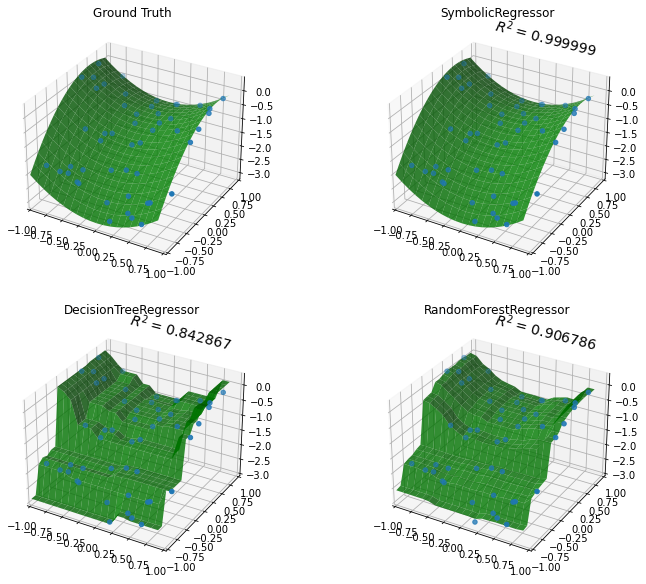

In [8]:
est_tree = DecisionTreeRegressor()
est_tree.fit(x_train,y_train)
est_rf = RandomForestRegressor()
est_rf.fit(x_train,y_train)

y_gp = est_gp.predict(np.c_[x0.ravel(),x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(x_test,y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(),x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(x_test,y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(),x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(x_test,y_test)

fig = plt.figure(figsize=(12,10))
for i,(y,score,title) in enumerate([(y_truth,None,"Ground Truth"),
                                   (y_gp,score_gp,"SymbolicRegressor"),
                                   (y_tree,score_tree,"DecisionTreeRegressor"),
                                    (y_rf,score_rf,"RandomForestRegressor")]):
    ax = fig.add_subplot(2,2,i+1,projection='3d')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    surf = ax.plot_surface(x0,x1,y,rstride=1,cstride=1,color='green',alpha=0.8)
    points = ax.scatter(x_train[:, 0], x_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)
plt.show()

## 检查回归器发现的公式


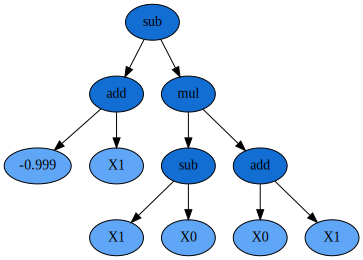

In [44]:
dot_data = est_gp._program.export_graphviz() 
# 导出图结构并查看
graph = graphviz.Source(dot_data)
graph

In [19]:
# 查看它的父母
print(est_gp._program.parents)
#  字典表示使用
{'method': 'Crossover',
 'parent_idx': 1555,
 'parent_nodes': [1, 2, 3],
 'donor_idx': 78,
 'donor_nodes': []}

{'method': 'Crossover', 'parent_idx': 1555, 'parent_nodes': range(1, 4), 'donor_idx': 78, 'donor_nodes': []}


{'donor_idx': 78,
 'donor_nodes': [],
 'method': 'Crossover',
 'parent_idx': 1555,
 'parent_nodes': [1, 2, 3]}

sub(sub(X1, 0.939), mul(sub(X1, X0), add(X0, X1)))


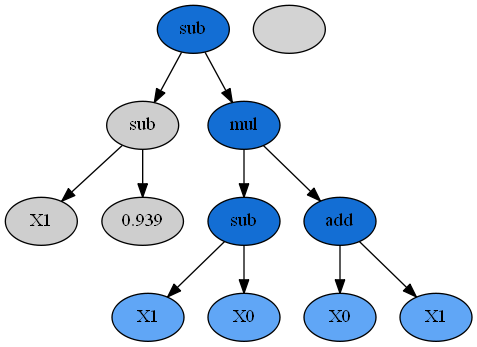

In [71]:
idx = est_gp._program.parents['parent_idx'] #读取父节点程序
fade_nodes = est_gp._program.parents['parent_nodes'] # 读取父节点中被替换的结点

print(est_gp._programs[-2][idx])
graph = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

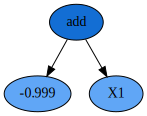

In [73]:
# 绘制父母图像
idx = est_gp._program.parents['donor_idx']
# fade_nodes表示在可视化中显示正在更改的结点
fade_nodes = est_gp._program.parents['donor_nodes']
dot_data = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = graphviz.Source(dot_data)
graph

## 输出公式
我们不希望使用同一个公式都要重新训练模型，即保存每次训练得到的公式。
1. 打印SymbolicRegressor,会得到最优的回归公式
2. 打印SymbolicTransformer时，会得到包括n_components个最优转换公式的列表

In [9]:
from gplearn import genetic

In [10]:
m1 = genetic.SymbolicRegressor(verbose=1,generations=3)
m1.fit(np.random.rand(10,5),np.random.rand(10))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.47          1291.11        3         0.274933              N/A      1.09s
   1     7.36          1.33336       11         0.262698              N/A      0.38s
   2     3.75         0.428849       13         0.251905              N/A      0.00s


SymbolicRegressor(generations=3, verbose=1)

In [11]:
print(m1)

div(mul(mul(div(X0, mul(0.565, X1)), X1), X2), add(X2, X1))


In [12]:
m2 = genetic.SymbolicTransformer(verbose=1,generations=3)
m2.fit(np.random.rand(10,5),np.random.rand(10))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.26         0.339164       11         0.770007              N/A      1.12s
   1    13.95         0.518821       67         0.819007              N/A      0.53s
   2     8.22         0.585724       65         0.825081              N/A      0.00s


SymbolicTransformer(generations=3, verbose=1)

In [13]:
print(m2)

[mul(sub(mul(div(sub(X3, X4), sub(X4, 0.237)), sub(sub(X0, X0), mul(div(X3, X4), div(X4, X0)))), sub(sub(div(X2, -0.797), mul(0.040, X4)), sub(div(X4, X3), mul(X4, X2)))), sub(add(div(add(X0, X4), sub(X2, -0.500)), mul(div(X2, -0.501), add(X0, X3))), add(sub(add(X3, X0), sub(X1, -0.917)), mul(div(X4, X4), X3)))),
 add(sub(add(mul(X4, -0.310), sub(X3, X4)), mul(mul(X3, X0), add(X3, X0))), div(sub(X2, X4), div(X1, X0))),
 div(add(-0.625, X4), add(X1, mul(div(X4, 0.112), X3))),
 div(div(sub(X2, X4), div(X1, X0)), add(X1, mul(add(X4, X0), X3))),
 sub(add(add(-0.845, mul(X4, -0.310)), sub(X3, X4)), mul(mul(X3, X0), mul(div(X4, X4), X3))),
 add(sub(X3, 0.404), div(sub(X2, X4), div(X1, X0))),
 div(sub(X2, X4), add(X1, mul(div(X4, X4), X3))),
 mul(sub(add(div(X1, X1), sub(X3, X4)), mul(mul(X3, X0), add(X3, X0))), 0.808),
 add(sub(add(add(-0.845, X2), sub(X3, X4)), div(X4, 0.112)), div(sub(X2, X4), div(X1, X0))),
 div(add(-0.625, X4), add(X1, mul(div(sub(X4, -0.868), div(X1, X0)), X3)))]


# Symbolic Transformer

此示例演示使用SymbolicTransformer自动生成新的非线性特征

## 准备波士顿房价数据

In [49]:
rng = check_random_state(0)
boston = load_boston()
perm = rng.permutation(boston.target.size)
boston.data = boston.data[perm]
boston.target = boston.target[perm]

## 使用岭回归训练前300

In [51]:
est_t = Ridge()
est_t.fit(boston.data[:300, :], boston.target[:300])
print(est_t.score(boston.data[300:, :], boston.target[300:]))

0.7593194530498839


## 训练转换器以生成新特征

In [54]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)
gp.fit(boston.data[:300, :], boston.target[:300])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04         0.339876        6         0.822502         0.675124     20.28s
   1     6.91         0.593562        7         0.836993         0.602468     27.90s
   2     5.07         0.730093        8          0.84063         0.704017     35.09s
   3     5.22         0.735525        5         0.847019         0.628351     37.75s
   4     6.24         0.734679       10         0.856612         0.565138     29.41s
   5     8.23         0.721433       18          0.85677         0.728095     30.07s
   6    10.20         0.717937       14         0.875233         0.619693     28.31s
   7    11.84         0.720667       14         0.875927         0.609363     27.05s
   8    12.56         0.733019       27         0.881705         0.390121  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    max_samples=0.9, n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=2000, random_state=0, verbose=1)

## 应用在整个数据集并测试

In [55]:
gp_features = gp.transform(boston.data)
new_boston = np.hstack((boston.data, gp_features))

In [57]:
est_t.fit(new_boston[:300, :], boston.target[:300])
print(est_t.score(new_boston[300:, :], boston.target[300:]))  # R2提升

0.8418372105182002


# 符号分类器 SymbolicClassfier

SymbolicClassifier能够找到非线性决策边界。对函数集和其他参数进行单独调整以更好地适应每个数据集也可以改善拟合。

## 准备数据 乳腺癌数据集

In [30]:
from sklearn.datasets import load_breast_cancer

In [47]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

## 训练分类器

In [34]:
est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400]) #拟合前400个数据

SymbolicClassifier(feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
                   parsimony_coefficient=0.01, random_state=1)

## 测试结果

In [37]:
y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
roc_auc_score(y_true, y_score)

0.9693786982248521

## 可视化解决方案

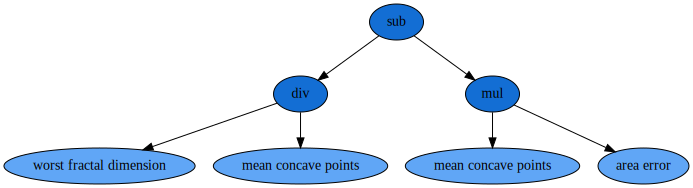

In [38]:
dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

# 其他用法

In [39]:
# LISP 样式的扁平树
print(est) 

sub(div(worst fractal dimension, mean concave points), mul(mean concave points, area error))


## 访问_Program包含多个属性和方法的底层对象

1. 回归器和分类器在进化最后一步找到最合适的程序
2. 转换器拥有_best_programs (长度为n_components的_program,在最后一代发现最不相关和最适合的程序)

In [59]:
for program in gp:
    print(program)
    print(program.raw_fitness_)

inv(sqrt(div(X10, mul(X5, inv(sqrt(div(add(-0.646, X10), mul(X11, mul(X5, mul(X5, mul(X5, mul(X5, inv(X12)))))))))))))
0.88827248367405
inv(sqrt(div(add(mul(X5, inv(X12)), X10), mul(X5, mul(X5, mul(X11, mul(X5, mul(X5, mul(X5, inv(X12))))))))))
0.8865306028786055
inv(sqrt(div(add(-0.646, X10), mul(X11, mul(X5, mul(X5, mul(X5, inv(sqrt(div(div(sqrt(div(add(-0.646, X10), inv(X12))), mul(X5, mul(X5, mul(X5, sqrt(div(X5, div(add(sqrt(div(X10, mul(X5, sqrt(mul(X5, div(X5, div(add(add(sqrt(mul(X5, inv(X12))), X10), X10), mul(X5, mul(X5, mul(X5, inv(X12))))))))))), X10), mul(X5, inv(X12))))))))), X5))))))))))
0.8801807205410794
inv(sqrt(div(add(mul(X5, inv(inv(sqrt(X9)))), X10), mul(X11, mul(X5, mul(X5, mul(X5, inv(sqrt(div(add(-0.646, X10), mul(X5, mul(mul(X5, mul(X5, inv(X12))), inv(X12)))))))))))))
0.8753890203022755
inv(sqrt(div(log(add(X10, X9)), mul(X5, sqrt(mul(X11, mul(X5, mul(X5, mul(X5, mul(X5, inv(X12)))))))))))
0.8731136715089409
inv(sqrt(div(add(add(mul(X5, mul(X5, inv(X12))), X1

In [61]:
# 访问最好的程序
print(gp._best_programs[0])

inv(sqrt(div(X10, mul(X5, inv(sqrt(div(add(-0.646, X10), mul(X11, mul(X5, mul(X5, mul(X5, mul(X5, inv(X12)))))))))))))


In [62]:
# 对于回归器
print(est_gp)
print(est_gp._program)
print(est_gp._program.raw_fitness_)

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))
sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))
0.0007814740353455652


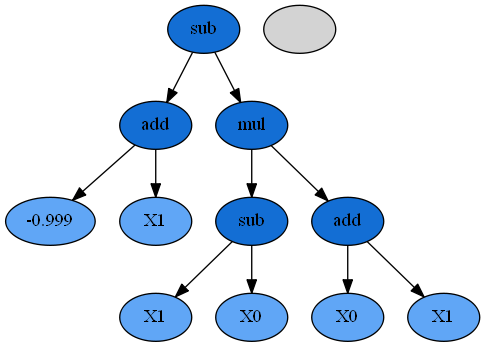

In [74]:
from IPython.display import Image
import pydotplus
graph = est_gp._program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

## 保存or加载模型

In [75]:
delattr(est, '_programs') # 删除属性

In [80]:
import pickle
with open('gp_model.pkl', 'wb') as f:
    pickle.dump(est, f)

In [81]:
with open('gp_model.pkl', 'rb') as f:
    est = pickle.load(f)

In [82]:
est

SymbolicClassifier(feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
                   parsimony_coefficient=0.01, random_state=1)

## 继续进化 
当generation太小，想继续又不丢失

In [ ]:
est.set_params(generations=20, warm_start=True)
est.fit(X, y)

# 自定义适应度函数

## 首先创建返回该值的函数 例如MAPE

In [2]:
def _mape(y, y_pred, w):
    """Calculate the mean absolute percentage error."""
    diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),
                             np.maximum(0.001, y)))
    # weights表示加权平均
    return 100. * np.average(diffs, weights=w)


## 创建fitness

In [13]:
mape = make_fitness(_mape, greater_is_better=False,wrap=False)

## 在训练时放入metric

In [14]:
est = SymbolicRegressor(metric=mape, verbose=1)

In [15]:
est.fit(x_train,y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.65      2.81994e+07        7           9.8228              N/A     10.38s
   1    20.36           246622       29          9.75926              N/A      7.31s
   2     4.72          30981.6       29          9.75926              N/A      5.99s
   3     3.62          6123.56       29          7.93397              N/A      5.51s
   4     7.92          3590.12       29          7.68948              N/A      5.38s
   5    19.78          5521.75       29          7.52992              N/A      5.66s
   6    30.68          3587.12       29          7.45627              N/A      5.72s
   7    33.78          3062.35       27          7.16365              N/A      5.59s
   8    34.69          3545.81       35          6.85306              N/A  

SymbolicRegressor(metric=<gplearn.fitness._Fitness object at 0x000002316F643F28>,
                  verbose=1)